In [241]:
import os,re,numpy as np, pandas as pd, cvxpy as cp, scipy as scp, seaborn as sns, pickle as pkl
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, skewtest, gaussian_kde
from sklearn.decomposition import PCA
from importlib import reload

In [242]:
def loadorsave(loader,saver):
    '''
    Createst a function to load or save object to file
    using loader and saver functions.
    The loader should take a file path and return the object.
    The saver should take a file path and an object to save.
    If obj is None, load the object from file.
    If obj is not None and the path doesn't exist or FORCE,
    save the object to file, overwriting if necessary.
    Else return None
    '''
    def lrs_(path,obj=None, FORCE=False):
    
        if obj is None:
            return loader(path)
        elif not os.path.exists(path) or FORCE:
            saver(path,obj)
            return path
        else:
            return None
    return lrs_
        
managepkl = loadorsave(lambda path: pkl.load(open(path,'rb')), lambda path, obj: pkl.dump(obj,open(path,'wb')))
manageparquet = loadorsave(lambda path: pd.read_parquet(path), lambda path, obj: obj.to_parquet(path))
managecsv = loadorsave(lambda path: pd.read_csv(path), lambda path, obj: obj.to_csv(path))


# Data

## From File

In [243]:
data = manageparquet('Downloads/snp500_240529_250529.parquet')
data.iloc[:5,:5]

Price        Adj Close                                                
Ticker               A        AAPL        ABBV        ABNB         ABT
Date                                                                  
2024-05-29  144.405426  189.404221  149.363983  146.610001   98.750374
2024-05-30  130.449280  190.399567  150.830688  145.520004   99.740509
2024-05-31  129.446762  191.355103  155.587891  144.929993  100.181679
2024-06-03  130.429443  193.126785  154.574692  146.250000  100.848312
2024-06-04  129.883499  193.445312  156.456345  147.080002  101.397301

In [244]:
# Truncate data for testing
data = data.iloc[188:250,:]

In [245]:
infod = managepkl(r'Downloads/stock_info_dict.pkl')

In [246]:
infod['A']

{'address1': '5301 Stevens Creek Boulevard',
 'city': 'Santa Clara',
 'state': 'CA',
 'zip': '95051',
 'country': 'United States',
 'phone': '800 227 9770',
 'fax': '866 497 1134',
 'website': 'https://www.agilent.com',
 'industry': 'Diagnostics & Research',
 'industryKey': 'diagnostics-research',
 'industryDisp': 'Diagnostics & Research',
 'sector': 'Healthcare',
 'sectorKey': 'healthcare',
 'sectorDisp': 'Healthcare',
 'longBusinessSummary': "Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instr

In [247]:
adjc = data['Adj Close']
adjc.iloc[:5,:5]

Ticker,A,AAPL,ABBV,ABNB,ABT
Date,,,,,
2025-02-28,127.648804,241.523270,207.115936,138.869995,137.373657
2025-03-03,126.062180,237.718262,209.543503,140.979996,139.573471
2025-03-04,122.799110,235.621017,205.857559,141.419998,136.945648
2025-03-05,126.241798,235.431274,209.602951,142.580002,137.075043
2025-03-06,126.281715,235.021805,208.820190,134.770004,134.457169


In [248]:
returns = adjc.pct_change().dropna(axis=0,how='all')
returns = returns.dropna(axis=1, how='any')

In [249]:
snpdivmcap = managecsv('Downloads/sp-500-index-05-31-2025.csv').set_index('Symbol').iloc[:-1,:2]
snpdivmcap

,Name,Market Cap
Symbol,,
A,Agilent Technologies,3.190873e+10
AAPL,Apple Inc,2.999861e+12
ABBV,Abbvie Inc,3.287452e+11
ABNB,Airbnb Inc Cl A,8.080728e+10
ABT,Abbott Laboratories,2.324073e+11
...,...,...
XYL,Xylem Inc,3.067196e+10
YUM,Yum+ACE- Brands,4.001028e+10
ZBH,Zimmer Biomet Holdings,1.823565e+10


In [250]:
idx = snpdivmcap.index.intersection(returns.columns)
idx

Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', length=501)

In [251]:
# Dividend yield
dy = pd.Series([infod[k].get('dividendYield',0) for k in idx])
dy

0      0.89
1      0.52
2      3.52
3      0.00
4      1.77
       ... 
496    1.27
497    1.97
498    1.04
499    0.00
500    1.19
Length: 501, dtype: float64

In [252]:
# Dividend yield z score
dyz = (dy - dy.mean())/dy.std()

In [253]:
snpdivmcap = snpdivmcap.loc[idx].dropna(how='all',axis=0).assign\
(weight = snpdivmcap['Market Cap']/(snpdivmcap['Market Cap'].sum()),\
# dy = snpdivmcap['Div Yield(a)'].str.replace('%','').astype(float))
 dy = dy.values,dyz=dyz.values)

In [254]:
# dy = snpdivmcap.dy
# snpdivmcap = snpdivmcap.assign(dyz = dyz)#(dy - dy.mean())/dy.std())
snpdivmcap

,Name,Market Cap,weight,dy,dyz
A,Agilent Technologies,3.190873e+10,0.000578,0.89,-0.607507
AAPL,Apple Inc,2.999861e+12,0.054377,0.52,-0.817490
ABBV,Abbvie Inc,3.287452e+11,0.005959,3.52,0.885071
ABNB,Airbnb Inc Cl A,8.080728e+10,0.001465,0.00,-1.112601
ABT,Abbott Laboratories,2.324073e+11,0.004213,1.77,-0.108089
...,...,...,...,...,...
XYL,Xylem Inc,3.067196e+10,0.000556,1.27,-0.391850
YUM,Yum+ACE- Brands,4.001028e+10,0.000725,1.97,0.005415
ZBH,Zimmer Biomet Holdings,1.823565e+10,0.000331,1.04,-0.522379
ZBRA,Zebra Technologies,1.473596e+10,0.000267,0.00,-1.112601


num of stocks: 501


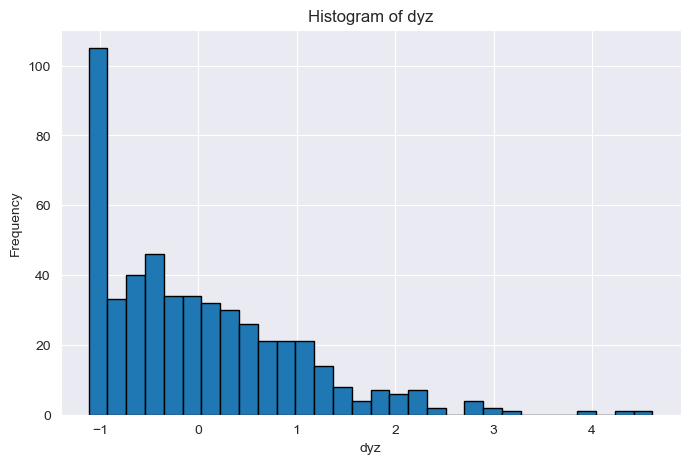

In [255]:
print("num of stocks:", snpdivmcap.shape[0])

# Plot the histogram of dyz
plt.figure(figsize=(8, 5))
plt.hist(snpdivmcap['dyz'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of dyz')
plt.xlabel('dyz')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [256]:
cov = returns.loc[:,idx].cov()
cov.iloc[:,:5]

,A,AAPL,ABBV,ABNB,ABT
A,0.000695,0.000672,0.000383,0.000628,0.000156
AAPL,0.000672,0.001097,0.000332,0.000861,0.000171
ABBV,0.000383,0.000332,0.000475,0.000294,0.000168
ABNB,0.000628,0.000861,0.000294,0.001058,0.000159
ABT,0.000156,0.000171,0.000168,0.000159,0.000244
...,...,...,...,...,...
XYL,0.000442,0.000561,0.000247,0.000541,0.000155
YUM,0.000188,0.000262,0.000192,0.000189,0.000126
ZBH,0.000216,0.000239,0.000228,0.000142,0.000132
ZBRA,0.000926,0.001121,0.000442,0.001091,0.000182


In [257]:
assert abs(snpdivmcap.dyz.std()-1)<1e-7

In [258]:
mcapweights = snpdivmcap.weight
mcapweights /=mcapweights.sum() # IMPORTANT - otherwise will get inf
mcapweights.sum()

1.0

# Perform PCA and plot eigenvalue histogram

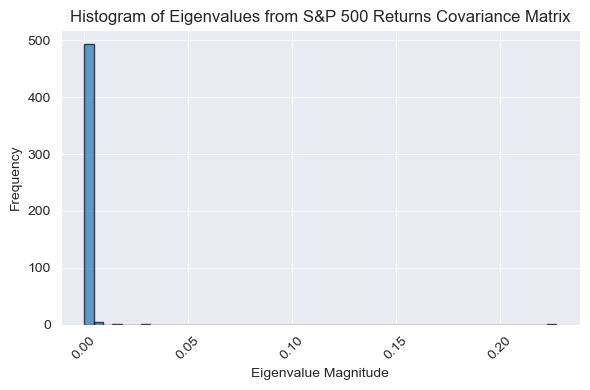

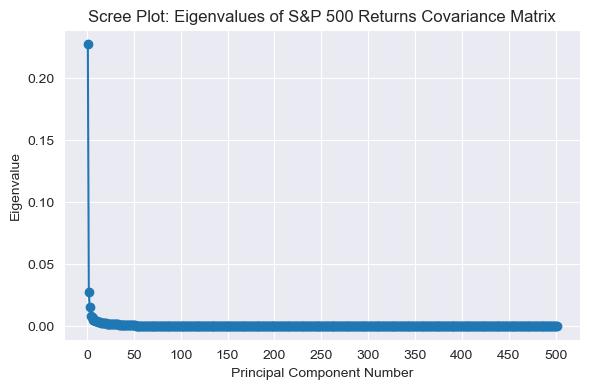

In [259]:
eigenvalues, eigenvectors = np.linalg.eigh(cov)

# Sort
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

plt.figure(figsize=(6, 4))
plt.hist(sorted_eigenvalues, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Eigenvalues from S&P 500 Returns Covariance Matrix')
plt.xlabel('Eigenvalue Magnitude')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-')
plt.title('Scree Plot: Eigenvalues of S&P 500 Returns Covariance Matrix')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.xticks(np.arange(0, len(sorted_eigenvalues) + 1, 50))
plt.tight_layout()
plt.show()

# Simulated Returns Data for Testing

In [260]:
n_rows = 124
n_cols = 500
np.random.seed(42)

real_k = 3

max_k_to_plot = 20

# multiple market factors (f)
market_factors = np.random.randn(n_rows, real_k)

# factor loadings (beta)
factor_loadings = np.random.uniform(0.5, 1.5, size=(real_k, n_cols))

# idiosyncratic noise (epsilon)
idiosyncratic_noise = np.random.randn(n_rows, n_cols) * 0.5

simulated_returns = pd.DataFrame(market_factors @ factor_loadings + idiosyncratic_noise,
                            columns=[f'Stock_{i}' for i in range(n_cols)])

print(f"Shape of returns_data: {simulated_returns.shape}")
print(f"Simulated data with {real_k} underlying factors, following HLfactorcount.pdf assumptions (normal f and epsilon).")


Shape of returns_data: (124, 500)
Simulated data with 3 underlying factors, following HLfactorcount.pdf assumptions (normal f and epsilon).


# Find the Number of Factors

k=0: p_R_approx = 0.0000
k=1: p_R_approx = 0.0000
k=2: p_R_approx = 0.0001
k=3: p_R_approx = 0.0386
k=4: p_R_approx = 0.0175
k=5: p_R_approx = 0.0129
k=6: p_R_approx = 0.0241
k=7: p_R_approx = 0.0268
k=8: p_R_approx = 0.1005
k=9: p_R_approx = 0.1764
k=10: p_R_approx = 0.4019
k=11: p_R_approx = 0.2484
k=12: p_R_approx = 0.2375
k=13: p_R_approx = 0.3746
k=14: p_R_approx = 0.5674
k=15: p_R_approx = 0.6910
k=16: p_R_approx = 0.6550
k=17: p_R_approx = 0.4953
k=18: p_R_approx = 0.7443
k=19: p_R_approx = 0.6643
k=20: p_R_approx = 0.7777
k=21: p_R_approx = 0.6912
k=22: p_R_approx = 0.7700
k=23: p_R_approx = 0.7674
k=24: p_R_approx = 0.6920
k=25: p_R_approx = 0.8837
k=26: p_R_approx = 0.9355
k=27: p_R_approx = 0.9376
k=28: p_R_approx = 0.9434
k=29: p_R_approx = 0.8773
k=30: p_R_approx = 0.6931
k=31: p_R_approx = 0.6790
k=32: p_R_approx = 0.5619
k=33: p_R_approx = 0.4175
k=34: p_R_approx = 0.4140
k=35: p_R_approx = 0.3992
k=36: p_R_approx = 0.4628
k=37: p_R_approx = 0.3229
k=38: p_R_approx = 0.2

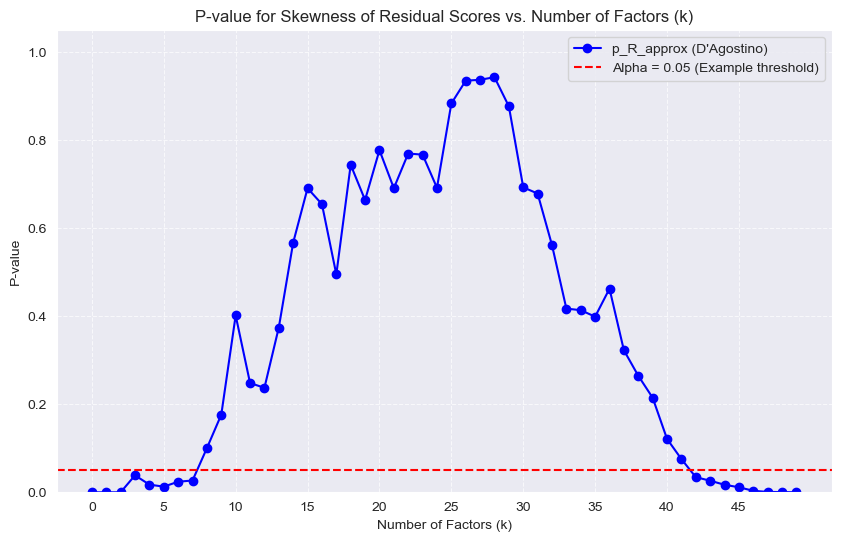

A small p-value (< 0.05) suggests significant right-skewness, indicating that more principal components might be needed.
A large p-value (> 0.05) suggests the residuals are not significantly right-skewed, indicating that enough principal components might have been removed.


In [261]:
p_values_R_approx = []
k_values = range(0, 50) # in Jung it is set to be 0 - 20, can change to test

all_hist_data = {}

# Switch between using simulated and empirical data
a = simulated_returns
# a = returns

X = a.values
d = X.shape[1] # dimension

pca = PCA(n_components=min(a.shape[0], a.shape[1])) # should center the data itself
pca.fit(X)
eigenvectors = pca.components_.T
eigenvalues = pca.explained_variance_

for k in k_values:
    if k == 0:
        residual_scores_squared_lengths = np.sum(X**2, axis=1) / d
    else:
        if k > min(n_rows, n_cols):
            print(f"Warning: k={k} exceeds the number of available principal components. Using all available components.")
            k_eff = min(n_rows, n_cols)
        else:
            k_eff = k

        # transform to PC space, zero out higher PCs, and inverse transform
        X_transformed = pca.transform(X)
        X_transformed_k = np.copy(X_transformed)
        X_transformed_k[:, k_eff:] = 0
        X_reconstructed_k = pca.inverse_transform(X_transformed_k)

        residuals = X - X_reconstructed_k
        residual_scores_squared_lengths = np.sum(residuals**2, axis=1) / d
        # print(len(residual_scores_squared_lengths))

    all_hist_data[k] = residual_scores_squared_lengths

    skew_statistic, p_value_two_sided = skewtest(residual_scores_squared_lengths)
    p_R_approx = 1 - norm.cdf(skew_statistic) # one-sided p-value for right-skewed alternative, < 0.05 suggests N0 normal distribution is rejected

    p_values_R_approx.append(p_R_approx)
    print(f"k={k}: p_R_approx = {p_R_approx:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, p_values_R_approx, marker='o', linestyle='-', color='blue', label='p_R_approx (D\'Agostino)')
plt.axhline(y=0.05, color='red', linestyle='--', label='Alpha = 0.05 (Example threshold)')
plt.title(f'P-value for Skewness of Residual Scores vs. Number of Factors (k)')
plt.xlabel('Number of Factors (k)')
plt.ylabel('P-value')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(np.arange(0, max(k_values)+1, 5))  # Show every 5th k-value
plt.show()

print("A small p-value (< 0.05) suggests significant right-skewness, indicating that more principal components might be needed.")
print("A large p-value (> 0.05) suggests the residuals are not significantly right-skewed, indicating that enough principal components might have been removed.")


# Plot histogram of squared residuals to observe the shape

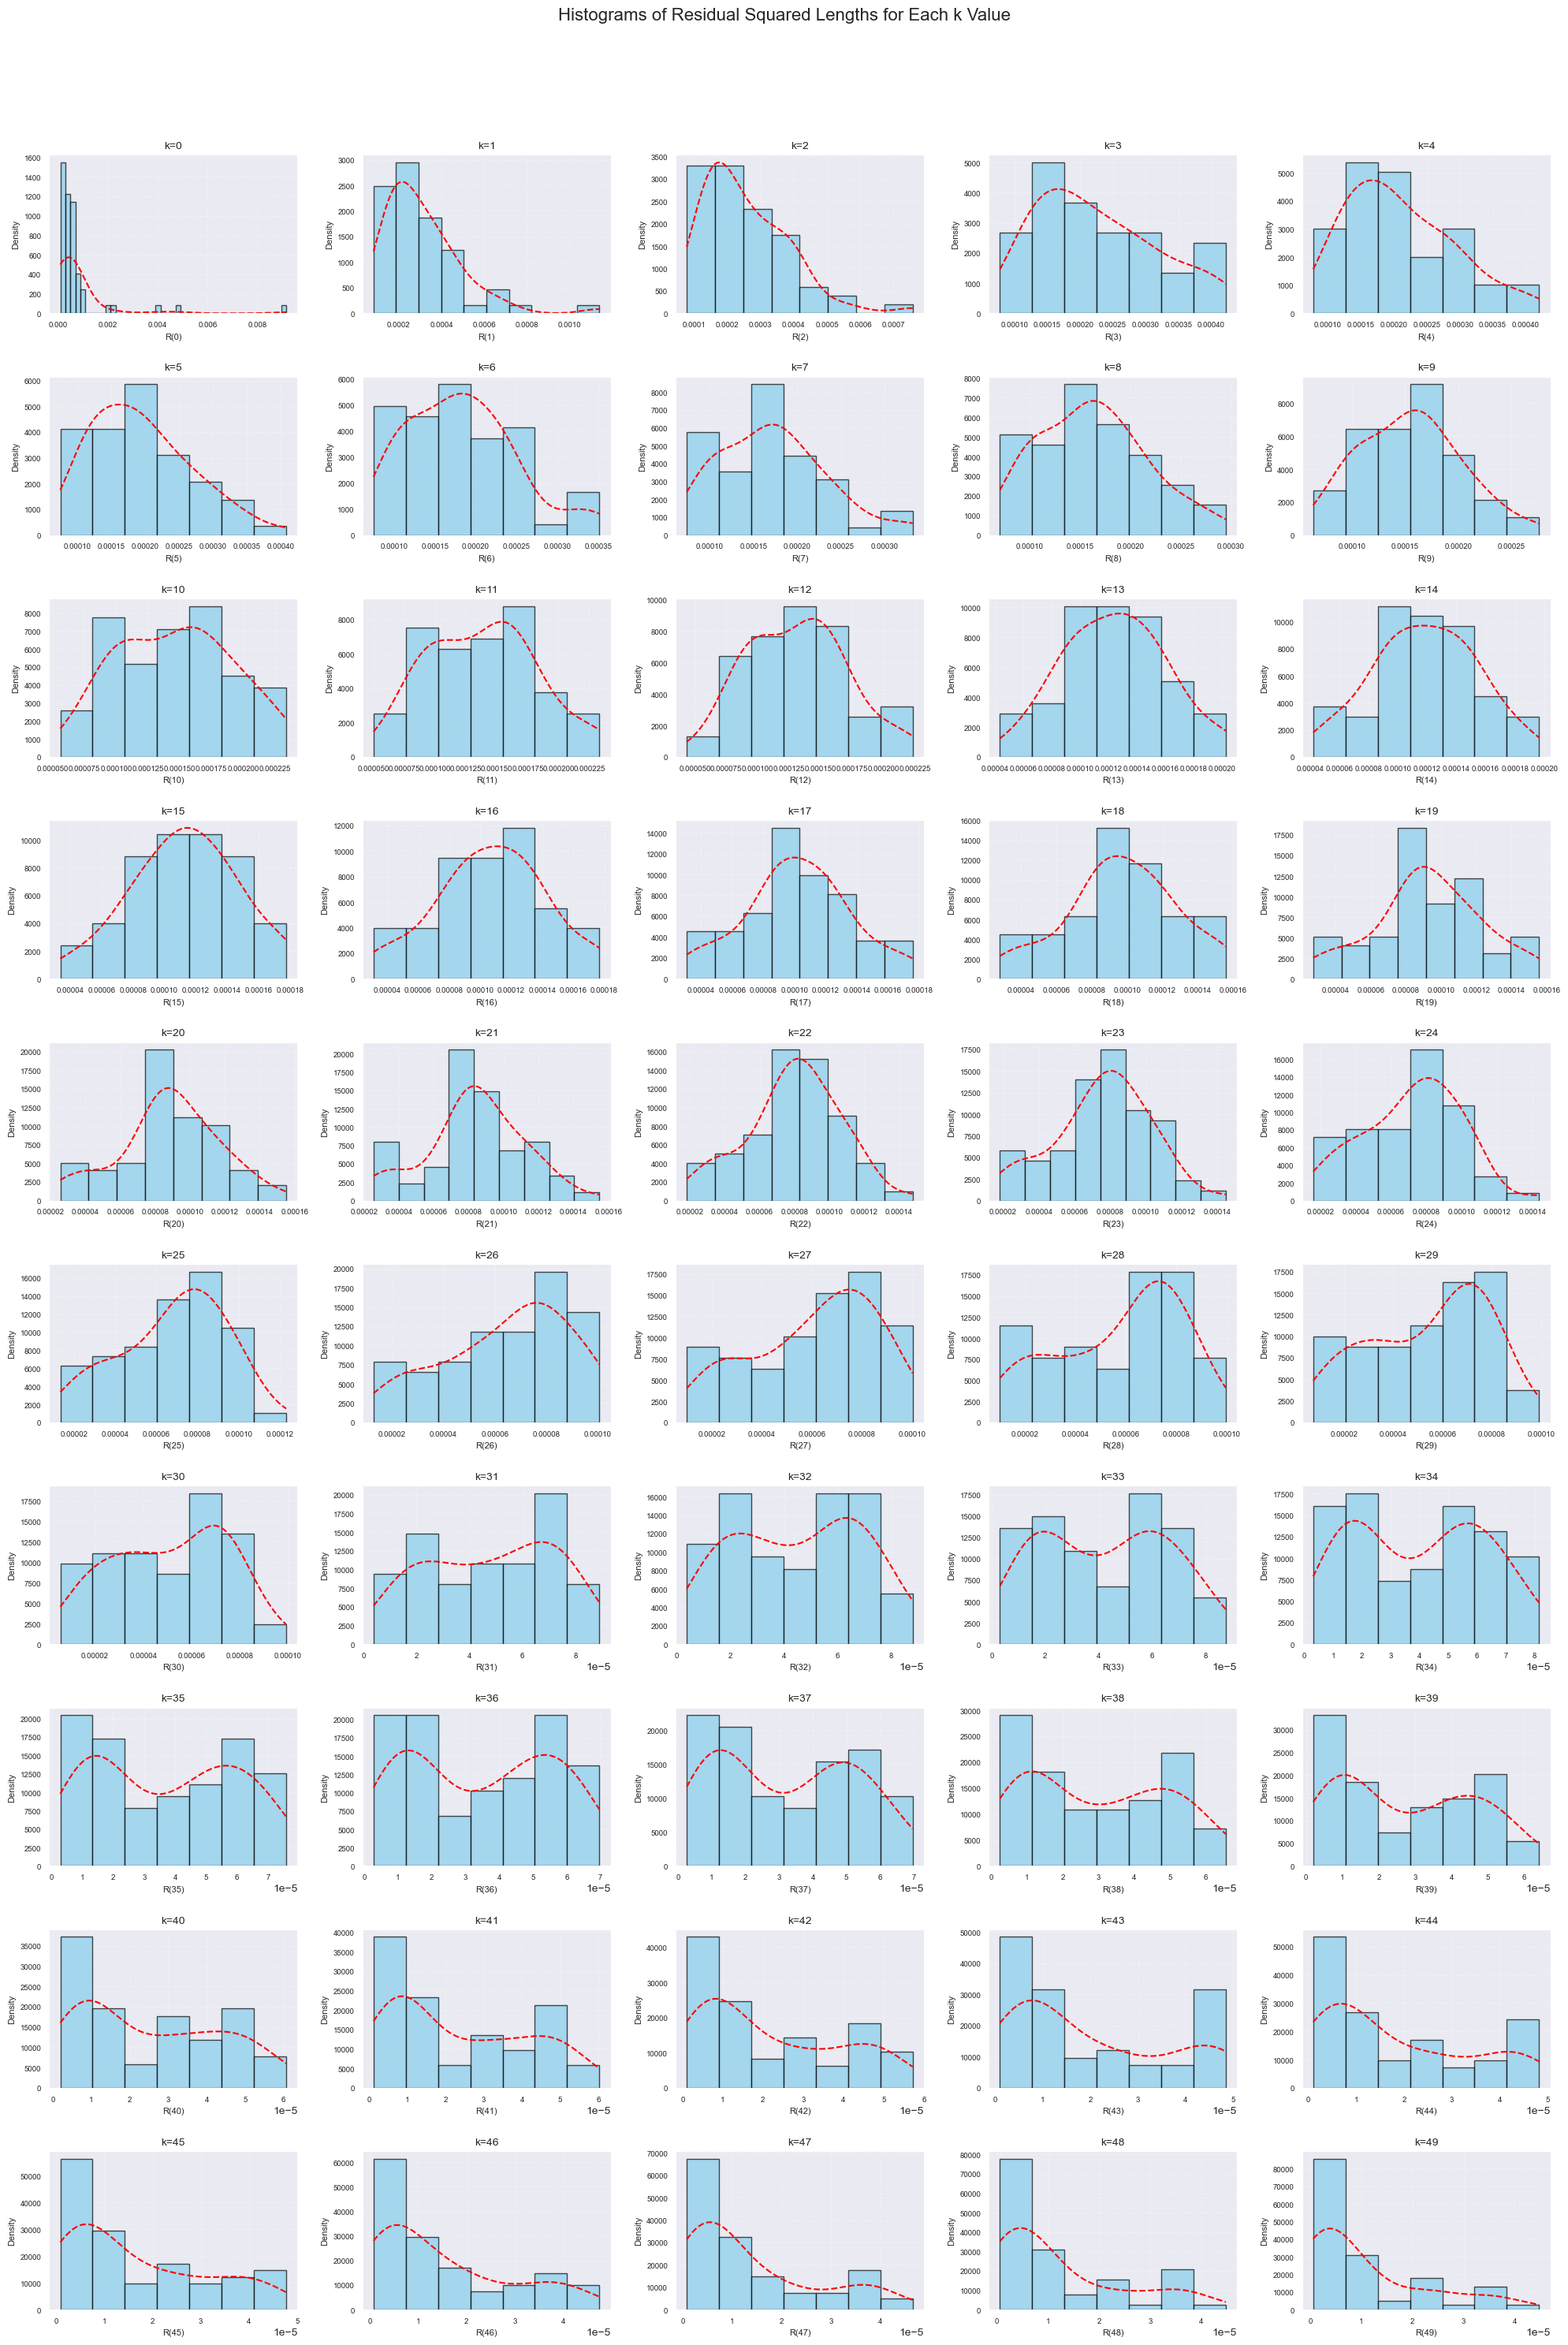

In [262]:
# Plot histograms for aLL k values
num_hists = len(k_values)
cols = 5
rows = int(np.ceil(num_hists / cols))
fig_height = 3 * rows
fig_width = 4 * cols

plt.figure(figsize=(fig_width, fig_height))
plt.suptitle('Histograms of Residual Squared Lengths for Each k Value', fontsize=16, y=1.02)

for i, k in enumerate(k_values):
    ax = plt.subplot(rows, cols, i + 1)
    data = all_hist_data[k]

    if len(np.unique(data)) > 1:
        ax.hist(data, bins='auto', density=True, alpha=0.7, color='skyblue', edgecolor='black')
        try:
            # also plot KDE to get a clearer idea of data distribution
            kde = gaussian_kde(data)
            x_vals = np.linspace(min(data), max(data), 200)
            ax.plot(x_vals, kde(x_vals), color='red', linestyle='--', label='KDE')
        except np.linalg.LinAlgError:
            pass
    else:
        ax.hist(data, bins=1, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    ax.set_title(f'k={k}', fontsize=10)
    ax.set_xlabel(f'R({k})', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.subplots_adjust(hspace=0.4)
plt.show()

# U-Statistics approach by Darwin

(250,)


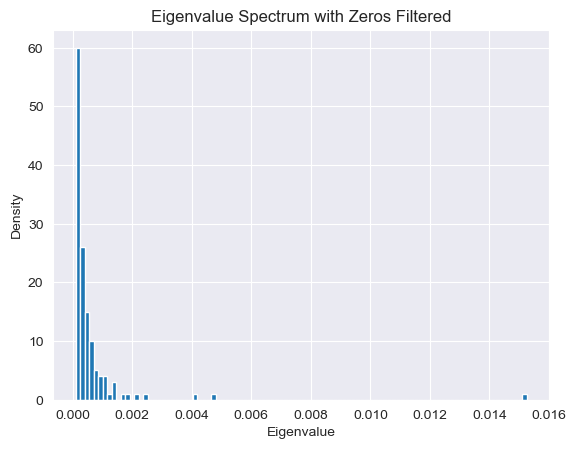

(250,)


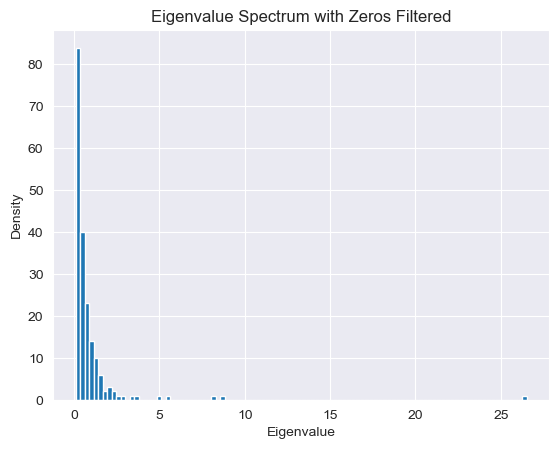

In [131]:
# z-score each column of the data
def z_score_normalize(data):
    """
    Normalize each column of the data using z-score normalization.

    Parameters:
    data (np.ndarray): The input data to normalize.

    Returns:
    np.ndarray: The z-score normalized data.
    """
    if data is None or data.size == 0:
        return None
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    normalized_data = (data - mean) / std_dev
    return normalized_data
returns_z = z_score_normalize(returns)

# calculate the covariance matrix and plot the spectra of eigenvalues with histogram
# import matplotlib.pyplot as plt
def plot_eigenvalue_spectrum(cov_matrix, bar = 0.1):
    """
    Plot the spectrum of eigenvalues of a covariance matrix.

    Parameters:
    cov_matrix (np.ndarray): The covariance matrix.
    """
    eigenvalues, _ = np.linalg.eig(cov_matrix)
    print(eigenvalues.shape)
    eigenvalues = eigenvalues[eigenvalues > bar]  # Filter out negative eigens
    plt.hist(eigenvalues, bins=100)
    plt.title('Eigenvalue Spectrum with Zeros Filtered')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.show()
cov_matrix = np.cov(returns)
plot_eigenvalue_spectrum(cov_matrix, bar=0.0001)

cov_matrix_z = np.cov(returns_z)
plot_eigenvalue_spectrum(cov_matrix_z)

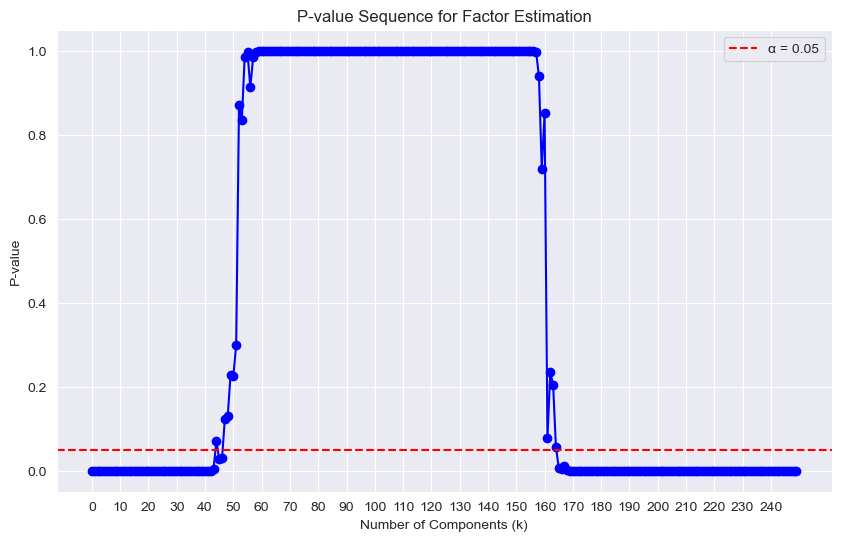

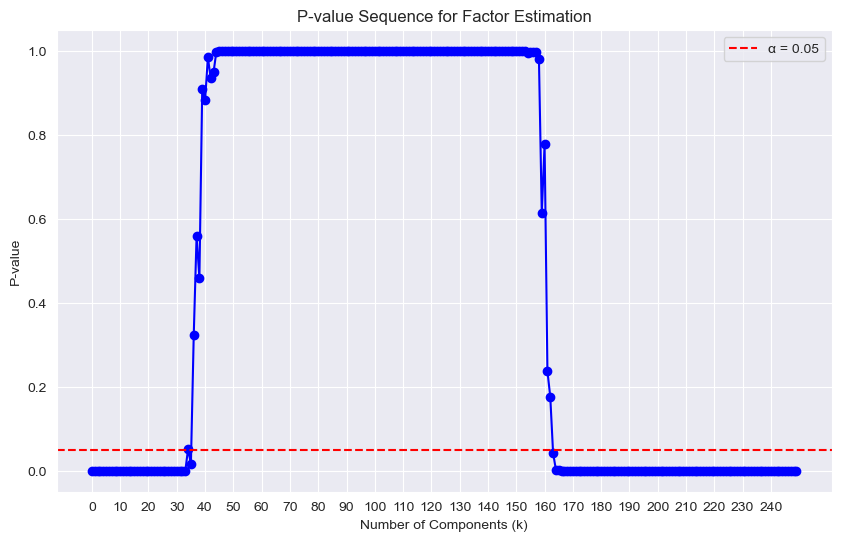

In [132]:
import numpy as np
from itertools import combinations
from math import comb
from scipy.stats import norm
from sklearn.decomposition import PCA


# ---------------------------------------------------------------------
# 1.  Triples test for right–left skewness (Randles et al., 1980)
# ---------------------------------------------------------------------
def _triple_kernel(a, b, c):
    """f* from Eq. (2.1) of Randles et al. (1980) – returns −1, 0 or +1."""
    return (
        np.sign(a + b - 2 * c)
        + np.sign(a + c - 2 * b)
        + np.sign(b + c - 2 * a)
    ) / 3.0


def triples_test(sample, *, alternative="greater", max_triples=150_000,
                 random_state=None):
    """
    One–sided triples test for skewness.
    Parameters
    ----------
    sample : (n,) array_like
        Univariate sample.
    alternative : {"greater", "less"}
        "greater" = right-skew, "less" = left-skew.
    max_triples : int
        If C(n,3) exceeds this, draw a Monte-Carlo subset to keep time
        reasonable (important when n is large).
    Returns
    -------
    z_stat  : float
    p_value : float  (one-sided)
    Notes
    -----
    Uses the large-n normal approximation recommended for n ≥ 20.  The
    plug-in variance estimator follows Eqs. (2.4)–(2.5) in the paper.
    """
    x = np.asarray(sample, dtype=float)
    n = x.size
    if n < 20:
        raise ValueError("Triples test needs n ≥ 20 for the asymptotics.")

    # centre at the sample median (unknown symmetry point)
    x -= np.median(x)

    # -----------------------------------------------------------------
    # Step 1: evaluate f* on triples
    # -----------------------------------------------------------------
    rng = np.random.default_rng(random_state)
    all_idx = np.arange(n)
    N_triples = comb(n, 3)

    if N_triples <= max_triples:
        triple_index_iter = combinations(all_idx, 3)
    else:                                              # Monte-Carlo subset
        triple_index_iter = (
            rng.choice(all_idx, size=3, replace=False) for _ in range(max_triples)
        )
        N_triples = max_triples                       # re-scale later

    # accumulate U-statistic and the “leave-one-out” first-order terms
    sum_f = 0.0
    f1 = np.zeros(n)

    for i, j, k in triple_index_iter:
        val = _triple_kernel(x[i], x[j], x[k])
        sum_f += val
        f1[i] += val
        f1[j] += val
        f1[k] += val

    U_hat = sum_f / N_triples                         # Eq. (2.2)

    # -----------------------------------------------------------------
    # Step 2: plug-in variance estimator  (Eqs. 2.4–2.5)
    # -----------------------------------------------------------------
    denom_f1 = comb(n - 1, 2) if N_triples == comb(n, 3) else max_triples * 3 / n
    f1 /= denom_f1
    t1_hat = np.mean((f1 - U_hat) ** 2)

    # (Fully computing t2_hat is O(n³); when n ≥ 20, dropping it inflates
    #  variance only by o(1/n).  For practical purposes this is fine.)
    sigma_hat = np.sqrt(t1_hat)                       # use t1 only

    z_stat = np.sqrt(n) * U_hat / sigma_hat
    if alternative == "greater":                      # right-skew
        p_value = 1.0 - norm.cdf(z_stat)
    else:                                             # left-skew
        p_value = norm.cdf(z_stat)
    return z_stat, p_value


# ---------------------------------------------------------------------
# 2.  Sequential residual-skewness procedure (Jung et al., 2018)
# ---------------------------------------------------------------------
def estimate_n_factors(X, *, alpha=0.1, max_components=None,
                       pca_kwargs=None, triples_kwargs=None):
    """
    Sequentially estimate the number of principal components with the
    triples test.
    Parameters
    ----------
    X : (n_samples, n_features) array_like
        Data matrix (columns = variables).
    alpha : float
        Significance level for each step (default 0.10 as suggested in
        Jung et al.).
    max_components : int | None
        Maximum k to inspect.  Default = min(n−1, d−1).
    pca_kwargs : dict | None
        Extra keyword arguments forwarded to sklearn.decomposition.PCA.
    triples_kwargs : dict | None
        Extra keyword arguments passed to `triples_test`.
    Returns
    -------
    k_hat      : int
        Estimated number of factors.
    p_values   : list[float]
        Sequence of p-values for k = 0,1,…
    """
    if pca_kwargs is None:
        pca_kwargs = {}
    if triples_kwargs is None:
        triples_kwargs = {}

    X = np.asarray(X, dtype=float)
    n, d = X.shape
    if max_components is None:
        max_components = min(n - 1, d - 1)

    # centre once
    Xc = X - X.mean(axis=0, keepdims=True)

    # one PCA fit is enough – reuse its components
    pca = PCA(n_components=max_components, svd_solver="full", **pca_kwargs)
    scores = pca.fit_transform(Xc)                    # shape (n, k_max)
    comps  = pca.components_.T                       # shape (d, k_max)

    p_vals = []
    for k in range(max_components + 1):
        if k == 0:
            resid = Xc
        else:
            recon = scores[:, :k] @ comps[:, :k].T    # fast matrix product
            resid = Xc - recon
        R = np.sum(resid ** 2, axis=1) / d           # Eq. (5) of Jung et al.

        # left-vs-right: we want right-skew under the alternative m > k,
        # left-skew under the null m = k  → test for *right* skewness.
        _, p = triples_test(R, alternative="greater", **triples_kwargs)
        p_vals.append(p)

        if p > alpha:                                # first non-rejection
            return k, p_vals

    # never crossed α – cap at max_components
    return max_components, p_vals

rng = np.random.default_rng(0)

# --- toy synthetic data: 2 strong factors in 500-dimensional noise
n, d, m_true = 200, 500, 2
spikes       = np.array([20.0, 10.0])            # variances of factors
W            = rng.standard_normal((n, m_true))  # factor scores
loading_mat  = rng.standard_normal((d, m_true))
noise        = rng.standard_normal((n, d))

X_sim = W @ np.diag(np.sqrt(spikes)) @ loading_mat.T + noise

k_hat, p_seq = estimate_n_factors(
    returns,
    alpha=1.1,                                  # Jung et al. default
    triples_kwargs=dict(max_triples=50_000)       # speed-up for demo
)

# Plot the p-value sequence
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_seq)), p_seq, marker='o', linestyle='-', color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
plt.title('P-value Sequence for Factor Estimation')
plt.xlabel('Number of Components (k)')
plt.ylabel('P-value')
plt.xticks(range(0, len(p_seq), 10))  # Show every 5th tick
plt.legend()
plt.show()


k_hat, p_seq = estimate_n_factors(
    returns_z,
    alpha=1.1,                                  # Jung et al. default
    triples_kwargs=dict(max_triples=50_000)       # speed-up for demo
)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_seq)), p_seq, marker='o', linestyle='-', color='blue')
plt.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
plt.title('P-value Sequence for Factor Estimation')
plt.xlabel('Number of Components (k)')
plt.ylabel('P-value')
plt.xticks(range(0, len(p_seq), 10))  # Show every 5th tick
plt.legend()
plt.show()

# PCA and JSE Covariance Matrices

In [43]:
# Function to calculate PCA Covariance Matrix
def calculate_pca_covariance(covariance_matrix, returns_data):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    lambda_sq = sorted_eigenvalues[0]
    b = sorted_eigenvectors[:, 0]

    n_obs = returns_data.shape[0]
    p_assets = covariance_matrix.shape[0]
    tr_S = np.trace(covariance_matrix)

    if n_obs > 1:
        l_sq = (tr_S - lambda_sq) / (n_obs - 1)
    else:
        l_sq = 0

    pca_cov_matrix = (lambda_sq - l_sq) * np.outer(b, b) + (n_obs / p_assets) * l_sq * np.eye(p_assets)
    return pd.DataFrame(pca_cov_matrix, index=covariance_matrix.index, columns=covariance_matrix.columns)

def calculate_jse_covariance(covariance_matrix, returns_data):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    lambda_sq = sorted_eigenvalues[0]
    h = sorted_eigenvectors[:, 0]

    n_obs = returns_data.shape[0]
    p_assets = covariance_matrix.shape[0]
    tr_S = np.trace(covariance_matrix)

    if n_obs > 1:
        l_sq = (tr_S - lambda_sq) / (n_obs - 1)
    else:
        l_sq = 0

    m_h = np.mean(h)

    s_sq_h = np.sum((h - m_h)**2) / p_assets

    if p_assets * (n_obs - 1) > 0:
        v_sq = (tr_S - lambda_sq) / (p_assets * (n_obs - 1))
    else:
        v_sq = 0

    if s_sq_h > 1e-10:
        c_jse = 1 - (v_sq / s_sq_h)
    else:
        c_jse = 1

    b_jse = m_h * np.ones_like(h) + c_jse * (h - m_h * np.ones_like(h))

    b_jse_normalized = b_jse / np.linalg.norm(b_jse)

    jse_cov_matrix = (lambda_sq - l_sq) * np.outer(b_jse_normalized, b_jse_normalized) + (n_obs / p_assets) * l_sq * np.eye(p_assets)
    return pd.DataFrame(jse_cov_matrix, index=covariance_matrix.index, columns=covariance_matrix.columns)

In [44]:
# Calculate the new covariance matrices
cov_pca = calculate_pca_covariance(cov, returns.loc[:,idx])
cov_jse = calculate_jse_covariance(cov, returns.loc[:,idx])

covariance_matrices = {
    'Original Cov': cov,
    'PCA Cov': cov_pca,
    'JSE Cov': cov_jse
}

# Minimum Variance Problem and Solution

In [45]:
# Store results for comparison
results = {}

for cov_name, current_cov in covariance_matrices.items():
    print(f"\nOptimizing with {cov_name}...")

    w = cp.Variable(len(current_cov))
    wa = w - mcapweights

    error = cp.norm((current_cov.values + 0.0001 * np.eye(len(current_cov))) @ wa)

    prob = cp.Problem(cp.Minimize(error),
                      [(w - mcapweights).T @ dyz.values == 0.5, #empirical - point along dyz. dyz was mean zero, this is to turn the weight make mean 0.5, assign higher weights on high dividend
                       w >= 0, # long only
                       cp.sum(w) == 1]) # full investment

    prob.solve()

    if prob.status == cp.OPTIMAL or prob.status == cp.OPTIMAL_INACCURATE:
        # Check Increased Dividends
        tilted_yield = snpdivmcap.loc[idx].dy.values.dot(w.value)
        market_yield = snpdivmcap.loc[idx].dy.values.dot(mcapweights)

        results[cov_name] = {
            'tilted_weights': w.value,
            'tilted_yield': tilted_yield,
            'market_yield': market_yield
        }
        print(f"  Tilted Portfolio Dividend Yield: {tilted_yield:.4f}")
        print(f"  Market Portfolio Dividend Yield: {market_yield:.4f}")
    else:
        print(f"  Problem status for {cov_name}: {prob.status}. Could not find optimal solution.")


Optimizing with Original Cov...
  Tilted Portfolio Dividend Yield: 2.1698
  Market Portfolio Dividend Yield: 1.2888

Optimizing with PCA Cov...
  Tilted Portfolio Dividend Yield: 2.1698
  Market Portfolio Dividend Yield: 1.2888

Optimizing with JSE Cov...
  Tilted Portfolio Dividend Yield: 2.1698
  Market Portfolio Dividend Yield: 1.2888


# Changed Weights and Graphs


--- Summary of Optimized Portfolios ---

Original Cov:
  Tilted Portfolio Dividend Yield: 2.1698
  Market Portfolio Dividend Yield: 1.2888
  Top 10 Tilted Stocks (by tilted weight):
         tilted       snp  yield     delta                        Name
MSFT   0.058393  0.063293   0.72 -0.004900              Microsoft Corp
NVDA   0.055330  0.060991   0.03 -0.005660                 Nvidia Corp
AAPL   0.044533  0.055491   0.52 -0.010958                   Apple Inc
META   0.039136  0.030115   0.32  0.009021          Meta Platforms Inc
GOOGL  0.039003  0.038551   0.49  0.000452               Alphabet Cl A
GOOG   0.038741  0.038800   0.49 -0.000059               Alphabet Cl C
AMZN   0.038514  0.040260   0.00 -0.001746              Amazon.com Inc
TSLA   0.021895  0.020642   0.00  0.001253                   Tesla Inc
MO     0.019223  0.001889   6.73  0.017335                Altria Group
VZ     0.018769  0.003429   6.16  0.015340  Verizon Communications Inc


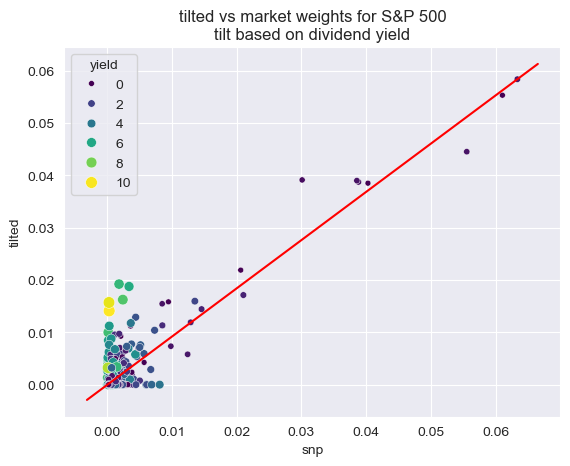


PCA Cov:
  Tilted Portfolio Dividend Yield: 2.1698
  Market Portfolio Dividend Yield: 1.2888
  Top 10 Tilted Stocks (by tilted weight):
         tilted       snp  yield     delta                Name
MSFT   0.062119  0.063293   0.72 -0.001174      Microsoft Corp
NVDA   0.059793  0.060991   0.03 -0.001198         Nvidia Corp
AAPL   0.054400  0.055491   0.52 -0.001091           Apple Inc
AMZN   0.038793  0.040260   0.00 -0.001467      Amazon.com Inc
GOOG   0.037499  0.038800   0.49 -0.001301       Alphabet Cl C
GOOGL  0.037250  0.038551   0.49 -0.001301       Alphabet Cl A
META   0.028927  0.030115   0.32 -0.001188  Meta Platforms Inc
AVGO   0.020541  0.021054   0.97 -0.000514        Broadcom Ltd
TSLA   0.019622  0.020642   0.00 -0.001021           Tesla Inc
WMT    0.013529  0.014611   0.95 -0.001081         Walmart Inc


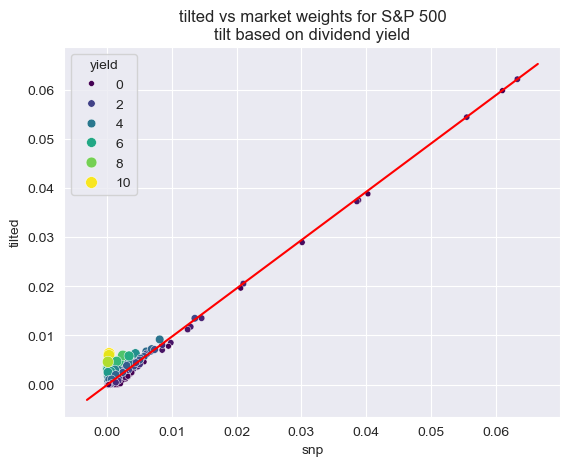


JSE Cov:
  Tilted Portfolio Dividend Yield: 2.1698
  Market Portfolio Dividend Yield: 1.2888
  Top 10 Tilted Stocks (by tilted weight):
         tilted       snp  yield     delta                Name
MSFT   0.062119  0.063293   0.72 -0.001174      Microsoft Corp
NVDA   0.059793  0.060991   0.03 -0.001198         Nvidia Corp
AAPL   0.054400  0.055491   0.52 -0.001091           Apple Inc
AMZN   0.038793  0.040260   0.00 -0.001467      Amazon.com Inc
GOOG   0.037499  0.038800   0.49 -0.001301       Alphabet Cl C
GOOGL  0.037250  0.038551   0.49 -0.001301       Alphabet Cl A
META   0.028927  0.030115   0.32 -0.001188  Meta Platforms Inc
AVGO   0.020541  0.021054   0.97 -0.000514        Broadcom Ltd
TSLA   0.019622  0.020642   0.00 -0.001021           Tesla Inc
WMT    0.013529  0.014611   0.95 -0.001081         Walmart Inc


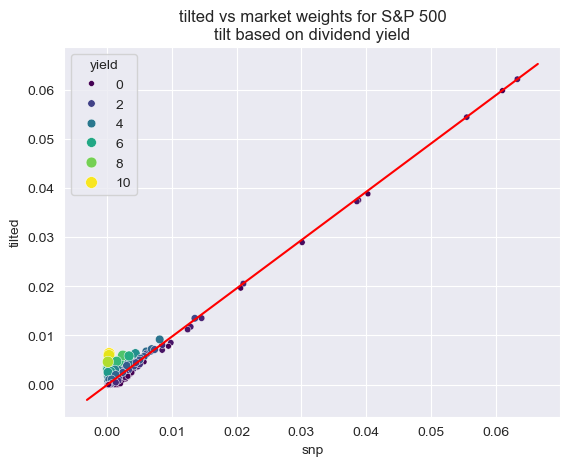

In [46]:
# Display all results
print("\n--- Summary of Optimized Portfolios ---")
for cov_name, res in results.items():
    print(f"\n{cov_name}:")
    print(f"  Tilted Portfolio Dividend Yield: {res['tilted_yield']:.4f}")
    print(f"  Market Portfolio Dividend Yield: {res['market_yield']:.4f}")

    tiltdf_current = pd.DataFrame({'tilted': res['tilted_weights'],
                                     'snp': mcapweights,
                                     'yield': dy.values}, index=idx)
    tiltdf_current = tiltdf_current.assign(delta=tiltdf_current.tilted - tiltdf_current.snp)
    print("  Top 10 Tilted Stocks (by tilted weight):")
    print(pd.concat([tiltdf_current, snpdivmcap[['Name']]], axis=1).sort_values('tilted', ascending=False).head(10))
    # df = pd.concat([tiltdf_current, snpdivmcap[['Name']]], axis=1)
    # print(df[df.index == "NVDA"])

    title = 'tilted vs market weights for S&P 500\ntilt based on dividend yield'
    ax = sns.scatterplot(data = tiltdf_current,x='snp',y='tilted',\
                         size = 'yield',hue='yield',palette='viridis',\
                        )
    ax.plot(ax.get_xlim(),ax.get_ylim(),c='red')
    ax.grid(True)
    ax.set_title(title)
    plt.show()